In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn import metrics
import seaborn as sns

### Get the Raw Data.

In [2]:
initial_df=pd.read_csv("LCD2_Dataset.csv")

/Users/jasonsmith/opt/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (32,33,34,41,42,43,49,51,73,75,76,88,89,96,97,98,99,100,101,102,103,104,105,106,107,123) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Get Rid of All Unnecessary Columns and Rows

First the colums.

In [141]:
all_col_names=set(initial_df.columns)
useful_col_names=set([
 'DATE',
 'REPORT_TYPE',
 'DailyAverageDryBulbTemperature',
 'DailyAverageRelativeHumidity',
 'DailyAverageStationPressure',
 'DailyAverageWindSpeed',
 'DailyMaximumDryBulbTemperature',
 'DailyMinimumDryBulbTemperature',
 'DailyPeakWindDirection',
 'DailyPeakWindSpeed',
 'DailyPrecipitation',
 'DailySnowDepth',
 'DailySnowfall',
 'DailySustainedWindDirection',
 'DailySustainedWindSpeed'])

In [142]:
drop_col_names=all_col_names.difference(useful_col_names)

In [143]:
weather=initial_df.drop(list(drop_col_names), axis=1)

Now the rows.

In [144]:
weather=weather[weather["REPORT_TYPE"]=="SOD  "]

In [145]:
weather=weather.drop(["REPORT_TYPE"], axis = 1)

In [146]:
weather=weather.reset_index()

In [147]:
weather=weather.drop(["index"], axis=1)

Now change the column names.

In [148]:
weather=weather.rename(columns={'DailySnowfall':"snowFall", 'DailyAverageWindSpeed':'WindSpd','DailyPeakWindDirection': 'PeakWindDir', 'DailyAverageStationPressure':'Pressure', 'DailyAverageRelativeHumidity':'Humidity', 'DailyAverageDryBulbTemperature':'DryBulbTemp', 'DailyMinimumDryBulbTemperature':'MinDryBulbTemp',  'DailyPeakWindSpeed': 'PeakWindSpeed', 'DailyPrecipitation':'Precip', 'DailyMaximumDryBulbTemperature':'MaxDryBulbTemp', 'DailySnowDepth':'SnowDepth', 'DailySustainedWindDirection':'SustainedWindDir', 'DailySustainedWindSpeed':'SustainedWindSpeed'})

### Create Temperature Drop and Humidity Increase Columns

It makes sense to create these features now, before rows are dropped later to balance the classes.  I discuss these two features below in the Feature Creation section.

In [149]:
weather["TempDrop"]=0.0

In [150]:
for i in np.arange(0,len(weather)-1):
    weather["TempDrop"][i+1]=weather["DryBulbTemp"][i]-weather["DryBulbTemp"][i+1]

<ipython-input-150-a8d124c3eecd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather["TempDrop"][i+1]=weather["DryBulbTemp"][i]-weather["DryBulbTemp"][i+1]


In [151]:
weather["HumIncrease"]=0.0

In [152]:
for i in np.arange(1,len(weather)-1):
    weather["HumIncrease"][i]=weather["Humidity"][i]-weather["Humidity"][i-1]

<ipython-input-152-cee8a59cbc57>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather["HumIncrease"][i]=weather["Humidity"][i]-weather["Humidity"][i-1]


### Create Label Column

#### The T Issue

In HW4 I had an issue dealing with the string "T" showing up in various places in the dataset.  According to the documentation, "T" stands for \emph{Trace Amount}.  

With this new knowledge about what "T" means, I originally chose to label all rows with a precipitation of "T" with the positive label $1$.  Later, I realized that this may be a mistake and could be effecting my overall accuracy.  

When I relabelled rows with a precipitation of "T" as $0$, my accuracy increased.  The following code represents this change. 

In [153]:
weather["Precip"]=weather.Precip.apply(lambda x: str(x))

In [154]:
weather["Rained"]="0"

In [155]:
def change(string):
    if string!='0' and string!="T":
        return 1
    else:
        return 0

In [156]:
weather["Rained"]=weather.Precip.apply(lambda x: change(x))

### Balance the classes

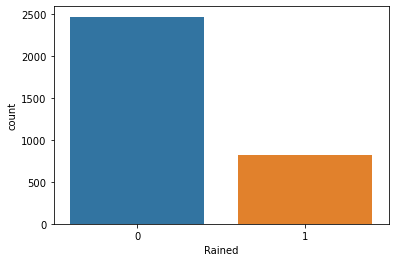

In [157]:
ax = sns.countplot(x="Rained", data=weather)

In [158]:
weather[weather["Rained"]==1].count()

DATE                  824
DryBulbTemp           824
Humidity              805
Pressure              823
WindSpd               824
MaxDryBulbTemp        824
MinDryBulbTemp        824
PeakWindDir           824
PeakWindSpeed         824
Precip                824
SnowDepth             824
snowFall              824
SustainedWindDir      824
SustainedWindSpeed    824
TempDrop              824
HumIncrease           805
Rained                824
dtype: int64

Since there was so few positively labelled rows that had NaN values, I chose to drop all rows with NaN values.

In [159]:
positive_df=weather[weather["Rained"]==1].dropna()

In [160]:
initial_neg_df=weather[weather["Rained"]==0].dropna()

In [161]:
negative_df=initial_neg_df.sample(n=804)

In [162]:
weather=pd.concat([positive_df, negative_df], ignore_index=True)

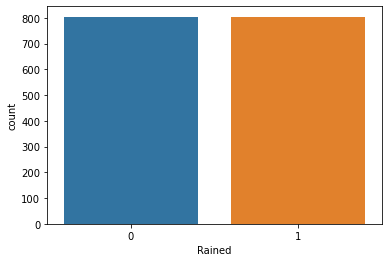

In [163]:
ax = sns.countplot(x="Rained", data=weather)

### Drop Precip.

In [164]:
weather=weather.drop(["Precip",'SnowDepth',
       'snowFall'], axis=1)

## Create features
This section has two subsections.  One subsection is devoted to "day of" features which did not help to increase my accuracy.  The other is devoted "day before" features that did help to increase my accuracy.  

#### Day of Features

##### Wind West

In [171]:
def west(dir):
    if 225.0 <= dir <= 315.0:
        return 1
    else:
        return 0

In [172]:
weather["WindWest"]=weather.PeakWindDir.apply(lambda x: west(x))

##### Seasons

In [182]:
weather["DATE"]=weather.DATE.apply(lambda x: x.split("-")[1])

In [183]:
weather["DATE"]=weather.DATE.apply(lambda x: int(x))

In [184]:
def season(date):
    if 3<= date <=5:
        return "Spring"
    elif 6<= date <= 8:
        return "Summer"
    elif 9<= date <= 11:
        return "Fall"
    else:
        return "Winter"

In [185]:
weather["Season"]=weather.DATE.apply(lambda x: season(x))

In [186]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

In [187]:
weather=encode_and_bind(weather, "Season")

In [296]:
weather=weather.drop(["DATE"], axis=1)

##### High Hum

In [317]:
def highHumidity(humidity):
    if humidity >= 65.0:
        return 1
    else:
        return 0

In [1697]:
weather3["HighHumidity"]=weather3.Humidity.apply(lambda x: highHumidity(x))

<ipython-input-1697-496261ac3f10>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather3["HighHumidity"]=weather3.Humidity.apply(lambda x: highHumidity(x))


##### Low Pressure

In [43]:
def lowPressure(pressure):
    if pressure <= 26.9:
        return 1
    else:
        return 0

In [44]:
weather["LowPressure"]=weather.Pressure.apply(lambda x: lowPressure(x))

##### Wind Speed

In [39]:
def Return1(wind_speed):
    if wind_speed >= 18.0:
        return 1
    else:
        return 0

In [41]:
weather["RainyWindSpeed"]=weather.SustainedWindSpeed.apply(lambda x: Return1(x))

Many of these "day of" features did not help to increase model accuracy at all and a couple increased model accuracy by at most $0.4\%$.  After many days of trying different combinations and creating more "day of" features, I realized why these features were not working.    

Big picture, they don't work because Boise has highly variable weather over the course of one day and over the course of a year.  In both Fall and Spring people often say, "If you don't like the weather, then just wait ten minutes."  So, when considering daily averages, it is possible to find two days that have similar \emph{averages} but different labels.

Now considering the finer details, a good example is my Low Pressure feature.  This feature is based on the barometric Pressure data.  The describe method used below gives the percentiles, min, max, etc for a series.

In [49]:
weather[weather["Rained"]==1]["Pressure"].describe()

count    804.000000
mean      26.971592
std        0.162540
min       26.470000
25%       26.870000
50%       26.960000
75%       27.080000
max       27.580000
Name: Pressure, dtype: float64

In [50]:
weather[weather["Rained"]==0]["Pressure"].describe()

count    804.000000
mean      27.078259
std        0.171986
min       26.630000
25%       26.960000
50%       27.050000
75%       27.180000
max       27.680000
Name: Pressure, dtype: float64

When designing a feature for a binary classifier, we want a value that does a decent job of separating the class labels.  Since pressure does not do this, it follows that my Low Pressure feature does not help the model.

##### Day Before Features 
Once I realized "day of" was not working, I turned to using a change from the day before to create features.  This worked.

##### Temperature Drop and Humidity Increase

The code for temp drop was mentioned above and is included below for reference.  The code for Humidity Increase is similar.  

The values in the Temp Drop column are positive if there was a temp drop from one day to the next and negative otherwise.  The values in the Humidity Increase column are positive if there was a humidity increase from one day to the next and negative otherwise.

In [52]:
"""weather["TempDrop"]=0.0"""

"""for i in np.arange(0,len(weather)-1):
    weather["TempDrop"][i+1]=weather["DryBulbTemp"][i]-weather["DryBulbTemp"][i+1]"""

'for i in np.arange(0,len(weather)-1):\n    weather["TempDrop"][i+1]=weather["DryBulbTemp"][i]-weather["DryBulbTemp"][i+1]'

##### Humidity Up 

Contrasting Humidty Increase to Low Pressure discussed above, we can see why my Humidity Up feature works.

In [54]:
weather[weather["Rained"]==1]["HumIncrease"].describe()

count    804.000000
mean       7.141791
std       12.932521
min      -27.000000
25%       -1.000000
50%        7.000000
75%       15.000000
max       46.000000
Name: HumIncrease, dtype: float64

In [55]:
weather[weather["Rained"]==0]["HumIncrease"].describe()

count    804.000000
mean      -2.324627
std        7.944254
min      -30.000000
25%       -7.000000
50%       -2.000000
75%        3.000000
max       27.000000
Name: HumIncrease, dtype: float64

Running out of time I settled for the following code to find an "optimal" value.

In [362]:
for i in np.arange(-5,10):
    print("------------")
    print(str(i))
    print(len(data[(data["Rained"]==1) & (data["HumIncrease"]>=i)])/805-len(data[(data["Rained"]==0) & (data["HumIncrease"]>=i)])/805)

------------
-5
0.15900621118012426
------------
-4
0.17267080745341612
------------
-3
0.20621118012422357
------------
-2
0.24968944099378887
------------
-1
0.27950310559006214
------------
0
0.31180124223602484
------------
1
0.33167701863354043
------------
2
0.3627329192546584
------------
3
0.37763975155279506
------------
4
0.3975155279503106
------------
5
0.4161490683229814
------------
6
0.4161490683229814
------------
7
0.40621118012422364
------------
8
0.4
------------
9
0.37888198757763975


In [165]:
def Hum_Up(hum_increase):
    if hum_increase >= 5:
        return 1
    else:
        return 0

In [166]:
weather["HumUp"]=weather.HumIncrease.apply(lambda x: Hum_Up(x))

### Check for colinearities

Using a pairplot similar to below I found some colinearities, played around with things for a while, and settled on the following numeric columns to keep.

In [167]:
weather_select=weather[['DryBulbTemp', 'Humidity', 'Pressure', 'PeakWindSpeed']]

In [168]:
weather_select.dtypes

DryBulbTemp      float64
Humidity         float64
Pressure         float64
PeakWindSpeed    float64
dtype: object

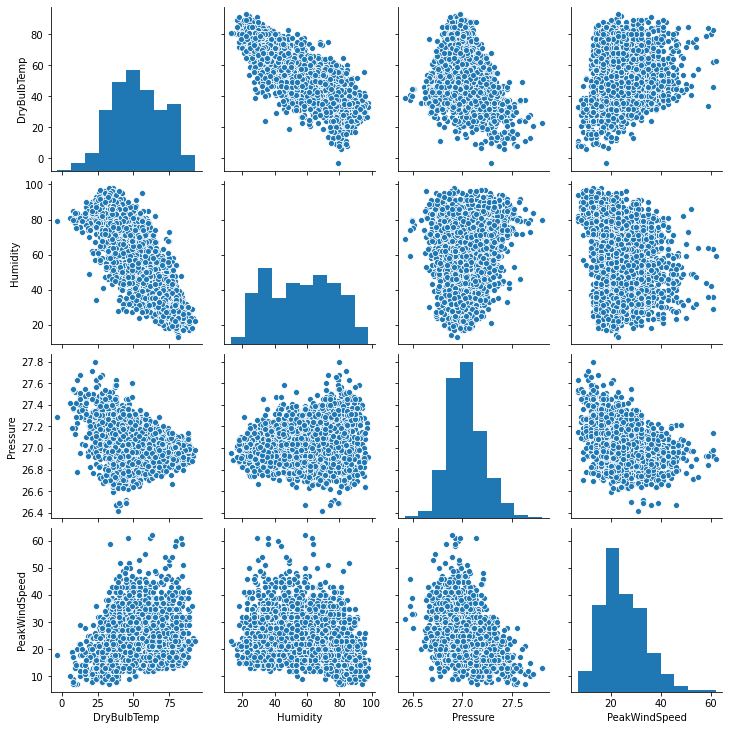

In [386]:
sns.pairplot(weather_select, diag_kind='hist')

### Drop Uncessary Columns 

In [173]:
columns_to_keep=[ 'Humidity', 'DryBulbTemp', 'Pressure', 'WindWest', 'SustainedWindSpeed', "TempDrop", "HumUp", "HumIncrease",
        'Rained'] # 'DryBulbTemp', 'WindWest', 'Pressure', "HumIncrease", 

In [174]:
weather=weather[columns_to_keep]

### Scaling

In [175]:
scaler=StandardScaler()

In [186]:
list(weather.columns)

['Humidity',
 'DryBulbTemp',
 'Pressure',
 'WindWest',
 'SustainedWindSpeed',
 'TempDrop',
 'HumUp',
 'HumIncrease',
 'Rained']

In [177]:
scaled_cols=[ 'DryBulbTemp', 'Pressure','TempDrop','HumIncrease',
'Humidity'] # 'DryBulbTemp', 'Pressure','HumIncrease',

In [178]:
weather[scaled_cols]=scaler.fit_transform(weather[scaled_cols])

<ipython-input-178-087bfb875ee5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather[scaled_cols]=scaler.fit_transform(weather[scaled_cols])
/Users/jasonsmith/opt/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


### Train the Model

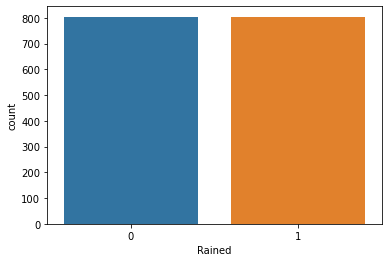

In [179]:
ax = sns.countplot(x="Rained", data=weather)

In [180]:
feature_columns=list(weather.columns)

In [181]:
feature_columns.remove("Rained")

In [182]:
X=weather[feature_columns]
y=weather.Rained

In [183]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.25, random_state=25)

In [184]:
model=LogisticRegression(max_iter=5000)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

### Accuracy

In [185]:
(y_pred==y_test).sum()/len(y_test)

0.8606965174129353

As you can see, the difference between my models accuracy and that of the dummy classifier is about 33%.  On HW4 the difference between my models accuracy and that of the dummy classifier was about 89%-72%=15%.  So, when considering this difference, I believe that I have met the requirement to increase the accuracy by 5%.  

In [72]:
dummy_clf = DummyClassifier(strategy="most_frequent")

In [73]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [74]:
y_dummy=dummy_clf.predict(X_test)

### Dummy Classifier Accuracy

In [75]:
(y_dummy==y_test).sum()/len(y_test)

0.4987593052109181